In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import Model
from keras.optimizers import RMSprop
from keras import regularizers
import keras.backend as K

Using TensorFlow backend.


In [2]:
# define constant
MAX_LEN = 80
EMD_DIM = 300

with open('punctuations.txt') as f:
    PUNCTS = f.read().decode('utf-8').split()

In [3]:
def tokenize(texts):
    sens = []
    for sen in texts:
        words = list(sen.decode('utf-8'))
        words = [w for w in words if w.strip() and w not in PUNCTS]
        sens.append(words)
    return sens

In [4]:
def to_int_seqs(seqs, vocab):
    rs = []
    for s in seqs:
        rs.append([vocab[w] if w in vocab else vocab[u'<unk>'] for w in s])
    return rs

In [5]:
def gen_emb_matrix(word_vecs, vocab):
    emb_matrix = np.zeros((len(vocab), EMD_DIM))
    for w,i in vocab.items():
        if w in word_vecs:
            emb_matrix[i] = word_vecs[w]
    return emb_matrix

In [6]:
def fscore(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(K.equal(y_true+y_pred, 2.), dtype='float32'))
    pred_p = K.sum(y_pred) + K.epsilon()
    actual_p = K.sum(y_true) + K.epsilon()
    precision = tp / pred_p
    recall = tp / actual_p
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [7]:
def weighted_binary_crossentropy(y_true, y_pred):
    p = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    loss = -(1.4 * y_true * K.log(p) + 0.6 * (1. - y_true) * K.log(1. - p))
    return K.mean(loss)

In [8]:
def my_model(vocab_size, emb_matrix, lr=0.001, loss='binary_crossentropy'):
    
    input1 = Input(shape=(MAX_LEN,))
    input2 = Input(shape=(MAX_LEN,))
    
    embedding = Embedding(vocab_size,
                          EMD_DIM,                          
                          weights=[emb_matrix],
                          input_length=MAX_LEN,
                          trainable=False)    
    
    # conv1d = Conv1D(128, 3, padding='same')
    # pooling1d = MaxPooling1D(pool_size=2, padding='same')
    
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))
    lstm2 = Bidirectional(LSTM(128, return_sequences=True))
        
    x1 = embedding(input1)
    x2 = embedding(input2)
        
    x1 = lstm1(x1)
    x2 = lstm1(x2)
    
    x1 = lstm2(x1)
    x2 = lstm2(x2)
    
    x3 = Multiply()([x1, x2])    
    
    x4 = Subtract()([x1, x2])
    x4 = Lambda(lambda x: K.abs(x))(x4)
    
    x = Concatenate(axis=-1)([x3, x4])
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, kernel_regularizer=regularizers.l2(1e-5))(x)
    
    pred = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-5))(x)
    
    model = Model(inputs=[input1, input2], outputs=pred)
    
    model.compile(optimizer=RMSprop(lr=lr, decay=1e-6),
                  loss=loss,
                  metrics=['accuracy', fscore])
    
    return model

In [9]:
# read data
data_train = pd.read_csv('train.csv', sep='\t', index_col=0, names=['sen1', 'sen2', 'label'])
data_val = pd.read_csv('validation.csv', sep='\t', index_col=0, names=['sen1', 'sen2', 'label'])

X1_train, X2_train, y_train = data_train['sen1'].as_matrix(), data_train['sen2'].as_matrix(), data_train['label'].as_matrix()
X1_val, X2_val, y_val = data_val['sen1'].as_matrix(), data_val['sen2'].as_matrix(), data_val['label'].as_matrix()

In [10]:
vocab = {u'<pad>':0, u'<unk>':1}
with open('./vocab.txt') as f:
    for line in f:
        vocab[line.decode('utf-8').split()[0]] = len(vocab)

In [11]:
word_vectors = {}
with open('./vectors.txt') as f:
    for line in f:
        vals = line.decode('utf-8').split()
        word_vectors[vals[0]] = vals[1:]

In [12]:
to_paded_seqs = lambda x:pad_sequences(to_int_seqs(tokenize(x), vocab),\
                    maxlen=MAX_LEN, padding='post', truncating='post')

X1_train, X2_train = to_paded_seqs(X1_train), to_paded_seqs(X2_train)
X1_val, X2_val = to_paded_seqs(X1_val), to_paded_seqs(X2_val)

In [13]:
emb_matrix = gen_emb_matrix(word_vectors, vocab)

In [18]:
model = my_model(len(vocab), emb_matrix, lr=0.0005, loss=weighted_binary_crossentropy)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 80, 300)      480900      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 80, 256)      439296      embedding_3[0][0]                
          

In [19]:
hist = model.fit([X1_train, X2_train], y_train, batch_size=128, epochs=6, validation_data=([X1_val, X2_val], y_val))

Train on 92230 samples, validate on 10247 samples
Epoch 1/6
92230/92230 [==============================] - 539s 6ms/step - loss: 0.4335 - acc: 0.7912 - fscore: 0.3238 - val_loss: 0.4142 - val_acc: 0.8165 - val_fscore: 0.3945
Epoch 2/6
92230/92230 [==============================] - 531s 6ms/step - loss: 0.3891 - acc: 0.8029 - fscore: 0.4687 - val_loss: 0.3984 - val_acc: 0.7640 - val_fscore: 0.5003
Epoch 3/6
92230/92230 [==============================] - 532s 6ms/step - loss: 0.3645 - acc: 0.8137 - fscore: 0.5178 - val_loss: 0.3739 - val_acc: 0.8210 - val_fscore: 0.5227
Epoch 4/6
92230/92230 [==============================] - 532s 6ms/step - loss: 0.3450 - acc: 0.8223 - fscore: 0.5487 - val_loss: 0.3673 - val_acc: 0.7946 - val_fscore: 0.5345
Epoch 5/6
92230/92230 [==============================] - 532s 6ms/step - loss: 0.3264 - acc: 0.8309 - fscore: 0.5771 - val_loss: 0.3627 - val_acc: 0.8031 - val_fscore: 0.5511
Epoch 6/6
92230/92230 [==============================] - 533s 6ms/step - lo

In [20]:
model.save('./my_model2.h5')

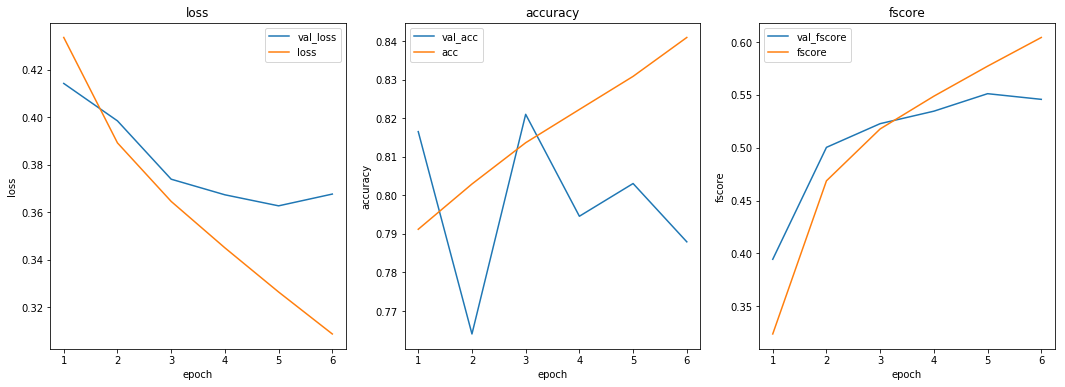

In [22]:
from matplotlib import pyplot as plt

his = hist.history
epochs = list(range(1, 7))
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('loss')
plt.plot(epochs, his['val_loss'], label='val_loss')
plt.plot(epochs, his['loss'], label='loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(132)
plt.title('accuracy')
plt.plot(epochs, his['val_acc'], label='val_acc')
plt.plot(epochs, his['acc'], label='acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(133)
plt.title('fscore')
plt.plot(epochs, his['val_fscore'], label='val_fscore')
plt.plot(epochs, his['fscore'], label='fscore')
plt.xlabel('epoch')
plt.ylabel('fscore')
plt.legend()

plt.show()